In [1]:
%%capture
!pip install transformers datasets faiss-gpu

In [13]:
import torch
torch.set_grad_enabled(False)
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [14]:
from PIL import Image
import requests
from transformers import AutoTokenizer, CLIPModel, CLIPFeatureExtractor

model_name = "openai/clip-vit-large-patch14"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)
feature_extractor = CLIPFeatureExtractor.from_pretrained(model_name)

In [6]:
!wget -O cat.jpg http://images.cocodataset.org/val2017/000000039769.jpg

--2022-12-26 08:01:04--  http://images.cocodataset.org/val2017/000000039769.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.78.28, 3.5.20.215, 54.231.162.113, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.78.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173131 (169K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>] 169.07K   248KB/s    in 0.7s    

2022-12-26 08:01:05 (248 KB/s) - ‘cat.jpg’ saved [173131/173131]



In [17]:
def get_text_embedding(text):
  ids = tokenizer.encode(text, return_tensors="pt")
  hiddens = model.text_model(ids).pooler_output
  hiddens = model.text_projection(hiddens)
  return hiddens.squeeze(0)

text_a = get_text_embedding('Two cats')
text_b = get_text_embedding('a cat')
text_c = get_text_embedding('a dog')
print(text_a.shape)

torch.Size([768])


In [18]:
def get_image_embedding(image):
  resized = feature_extractor(image)['pixel_values'][0]
  image = torch.from_numpy(resized).unsqueeze(0).cuda()
  hiddens = model.vision_model(image).pooler_output
  hiddens = model.visual_projection(hiddens)
  return hiddens.squeeze(0)

image = Image.open('cat.jpg')
cat_img = get_image_embedding(image)
cat_img.shape

torch.Size([768])

In [19]:
def cos_sim(a, b):
  return torch.dot(a, b) / torch.norm(a) / torch.norm(b)

cos_sim(text_a, cat_img), cos_sim(text_b, cat_img), cos_sim(text_c, cat_img)

(tensor(0.2203), tensor(0.1590), tensor(0.1035))

In [20]:
text_x = get_text_embedding('cats are sleeping')
text_y = get_text_embedding('cats are running')

cos_sim(text_x, cat_img), cos_sim(text_y, cat_img)

(tensor(0.2436), tensor(0.1941))

## 스포츠

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!unzip /content/drive/MyDrive/2022Python소수전공/자료/sports-image.zip -d sports/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: sports/pole vault/009.jpg  
  inflating: sports/pole vault/010.jpg  
  inflating: sports/pole vault/011.jpg  
  inflating: sports/pole vault/012.jpg  
  inflating: sports/pole vault/013.jpg  
  inflating: sports/pole vault/014.jpg  
  inflating: sports/pole vault/015.jpg  
  inflating: sports/pole vault/016.jpg  
  inflating: sports/pole vault/017.jpg  
  inflating: sports/pole vault/018.jpg  
  inflating: sports/pole vault/019.jpg  
  inflating: sports/pole vault/020.jpg  
  inflating: sports/pole vault/021.jpg  
  inflating: sports/pole vault/022.jpg  
  inflating: sports/pole vault/023.jpg  
  inflating: sports/pole vault/024.jpg  
  inflating: sports/pole vault/025.jpg  
  inflating: sports/pole vault/026.jpg  
  inflating: sports/pole vault/027.jpg  
  inflating: sports/pole vault/028.jpg  
  inflating: sports/pole vault/029.jpg  
  inflating: sports/pole vault/030.jpg  
  inflating: sports/pole vault/031.jpg  
  inflating: sports/p

In [24]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="sports/", split="train")
dataset

Resolving data files:   0%|          | 0/13572 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-01800b935234b414/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'label'],
    num_rows: 13572
})

In [25]:
import faiss
index = faiss.IndexFlatIP(768)

In [26]:
index = faiss.read_index("/content/drive/MyDrive/2022Python소수전공/자료/sports-768.faiss")

In [27]:
index.ntotal

13572

In [28]:
import numpy as np
from tqdm.auto import tqdm
#for item in tqdm(dataset):
#  image = item['image']
#  emb = get_image_embedding(image).cpu().numpy()
#  emb = np.expand_dims(emb, 0)
#  faiss.normalize_L2(emb)
#  index.add(emb)

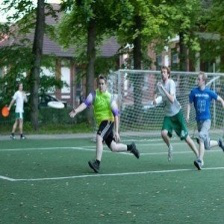

class 91 score 0.23155443370342255


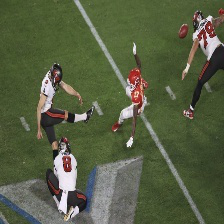

class 31 score 0.22979286313056946


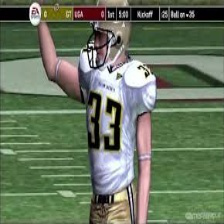

class 31 score 0.22772400081157684


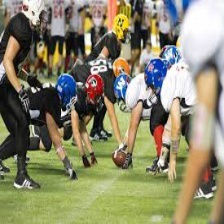

class 31 score 0.22507435083389282


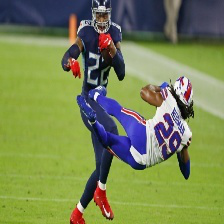

class 31 score 0.22365234792232513


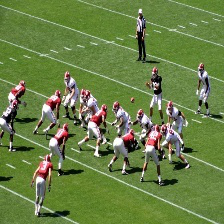

class 31 score 0.22175492346286774


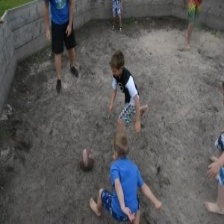

class 34 score 0.21955059468746185


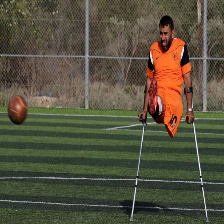

class 1 score 0.2195492684841156


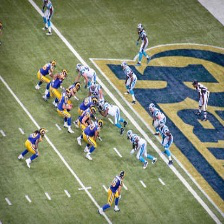

class 31 score 0.21892869472503662


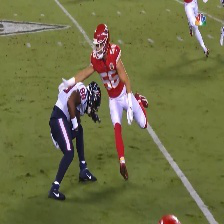

class 31 score 0.2180122286081314


In [42]:
def search_image_by_text(text, k=10):
  emb = get_text_embedding(text).cpu()
  emb = np.expand_dims(emb, 0)
  faiss.normalize_L2(emb)
  dists, indices = index.search(emb, k=k)

  for d, i in zip(dists[0], indices[0]):
    item = dataset[i.item()]
    display(item['image'])
    print(f"class {item['label']} score {d}")

search_image_by_text("football")

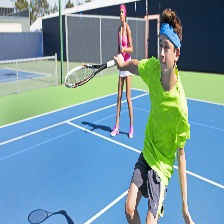

class 87 score 0.3053451180458069


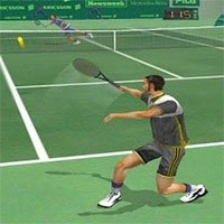

class 87 score 0.28231745958328247


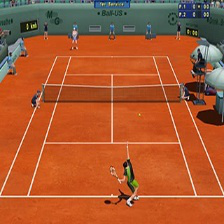

class 87 score 0.270895391702652


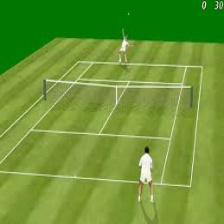

class 87 score 0.268374502658844


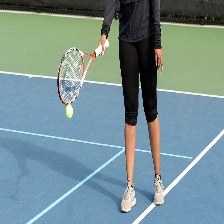

class 87 score 0.26793959736824036


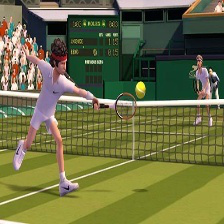

class 87 score 0.26609668135643005


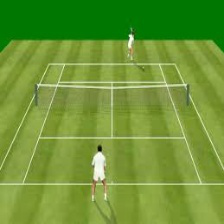

class 87 score 0.26602619886398315


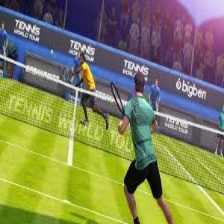

class 87 score 0.26539456844329834


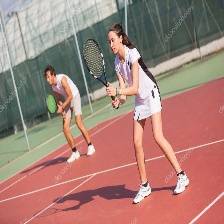

class 87 score 0.26445114612579346


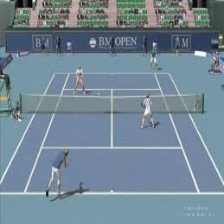

class 87 score 0.264235258102417


In [43]:
search_image_by_text("tennis")